In [37]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

working on advisarial attacks to a notebook that we have  already tested and are familiar  with 

### Logistics
Although this tutorial is intended to be mainly read as a static page, because, as mentioned above, you can also download the notebooks for each section, we briefly mention the requirements for running the full examples seen here.  Specifically, all example here use Python 3.7 (though should be compatible with 3.6), and make use of the following libraries:
  - [pytorch 1.0](https://pytorch.org)
  - [cvxpy 1.0](http://cvxpy.org)
  - numpy/scipy/PIL/etc

Ideally, the precise version number should not matter, and the approach should be compatible with e.g. pytorch 0.4.x (but not earlier), earlier versions of pillow, etc.  We installed all this software by with a fresh install of [Anaconda](https://www.anaconda.com/) (which includes all of the needed libraries except PyTorch and cvxpy), then used the `conda install <package>` or `pip install <package>` commands to install all the relevant software.  We also provide a docker container capable of running all the notebooks in our github repository.  You will only need cvxpy for some of the optimization-related approaches we discuss, and most of the tutorial can be done without this tool, but PyTorch is used quite heavily throughout.

Many of the simpler examples are quite fast to compute, and so we just implement them on a CPU.  For the more time-intensive operations, however (especially the various types of adverarial training), it is necessarly to train the systems on a GPU to have any hope of being computationally efficient.  Thus, in order to run these later examples, you will also need CUDA installed with the above version of PyTorch.

## QUESTION 1 

1) Recreate the adversarial examples from Chapter 1 of https://adversarial-ml-tutorial.org/introduction/ (Links to an external site.) but in this case train the pig to be labeled as a 'crayfish' (index 124), 'vizsla' (index 211), and 'cowboy boot' (index 514).  Compare the perturbation images for each of these adversarial examples, first by plotting them side by side, and then looking at the L2, L1, and L-infty norms between each image (delta in the notebook), as well as between each of the perturbed images (pig + delta).  Can you identify any consistencies between the different adversarial perturbations (the delta's)?  Display the modified image when the perturbation is amplified, i.e. show pig + 10*delta.  Does this help identify any trends?

## Diving right in



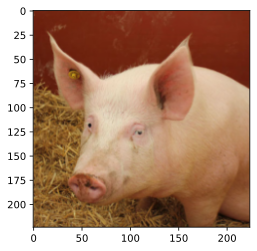

In [2]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [42]:
from numpy import linalg as lg 

In [43]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [25]:
# form predictions
pred = model(norm(pig_tensor))

Pred now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes (i.e., if you wanted to convert this to a probability vector, you would apply the softmax operator to this vector).  To find the highest likelihood class, we simply take the index of maximum value in this vector, and we can look this up in a list of imagenet classes to find the corresponding label.

In [26]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])



hog


Loooking good! (note that ImageNet has one class correpsonding to both "hog" and "pig", so this is the correct label).  We should note that this is the first pig image we tried here, so it doesn't take any tweaking to get a result like this ... modern image classifiers are pretty impressive.

In [58]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

def adversarial_targeted_attack(target = 404, img_ = pig_tensor, norm_ = "infty", print_ = True, plot_ = True, times_ten_ = False, learning_rate = 5e-3, epsilon = 2./255):
    delta = torch.zeros_like(pig_tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=learning_rate)
    for t in range(100):
        pred = model(norm(pig_tensor + delta))
        loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
                nn.CrossEntropyLoss()(pred, torch.LongTensor([target])))
        if t % 10 == 0 and print_ == True:
            print(t, loss.item())
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        if norm_ == "infty":
            delta.data.clamp_(-epsilon, epsilon)
        if norm_ == "two":
            modifier = (epsilon)*(lg.norm(delta.detach().numpy().flatten(), ord=2))
            #delta.data = delta.data * modifier
        if norm_ == "one":
            modifier = (epsilon)*(lg.norm(delta.detach().numpy().flatten(), ord=2))
            delta.data = delta * modifier
            
        
    if print_ == True:
        print(f"The True class Probability Is:", nn.Softmax(dim=1)(pred)[0,341].item())
        print(f"The Predicted Classification Is:", imagenet_classes[pred.max(dim=1)[1].item()])
        print(f"The Prediction Confidence Is:", nn.Softmax(dim=1)(pred)[0,max_class].item())
        
    if plot_ == True:
        figure(num=None,figsize=(15,15),dpi=80,facecolor='w',edgecolor='k')
        
        plt.subplot(1, 3, 1)
        plt.imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
        plt.title("Original Pig")
        
        plt.subplot(1, 3, 2)
        plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
        plt.title("50*Delta")
        
        if times_ten_ == False:
            plt.subplot(1, 3, 3)
            plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
            plt.title("Resulting Image")
            
        if times_ten_ == True:
            plt.subplot(1, 3, 3)
            plt.imshow((pig_tensor + 10*delta)[0].detach().numpy().transpose(1,2,0))
            plt.title("Resulting Image")
        
    plt.show()
    return([imagenet_classes[pred.max(dim=1)[1].item()], nn.Softmax(dim=1)(pred)[0,max_class].item(), lg.norm(delta.detach().numpy().flatten(), ord=2)])

seeing how the function  does  for the Crayfish with norrm infinity
0 17.700895309448242
10 -5.494589805603027
20 -18.179533004760742
30 -35.379756927490234
40 -57.50188064575195
50 -72.0414047241211
60 -81.7297592163086
70 -96.34983825683594
80 -106.19902801513672
90 -119.7172622680664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: goldfish
The Prediction Confidence Is: 0.0


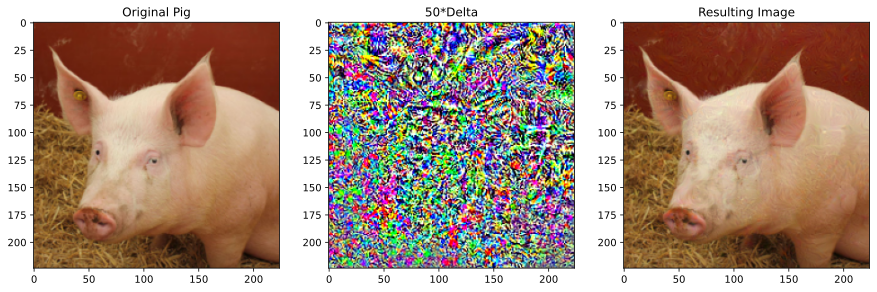

seeing how the function  does  for the Crayfish with norrm L1
0 17.700895309448242
10 -5.494589805603027
20 -18.179533004760742
30 -35.379756927490234
40 -57.50188064575195
50 -72.0414047241211
60 -81.7297592163086
70 -96.34983825683594
80 -106.19902801513672
90 -119.7172622680664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: goldfish
The Prediction Confidence Is: 0.0


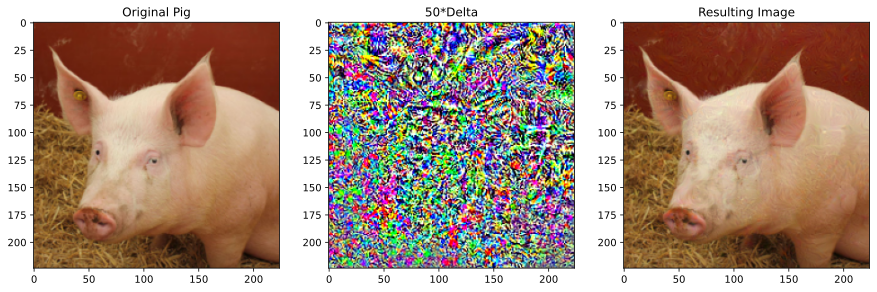

seeing how the function  does  for the Crayfish with norrm L2
0 17.700895309448242
10 -5.494589805603027
20 -18.179533004760742
30 -35.379756927490234
40 -57.50188064575195
50 -72.0414047241211
60 -81.7297592163086
70 -96.34983825683594
80 -106.19902801513672
90 -119.7172622680664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: goldfish
The Prediction Confidence Is: 0.0


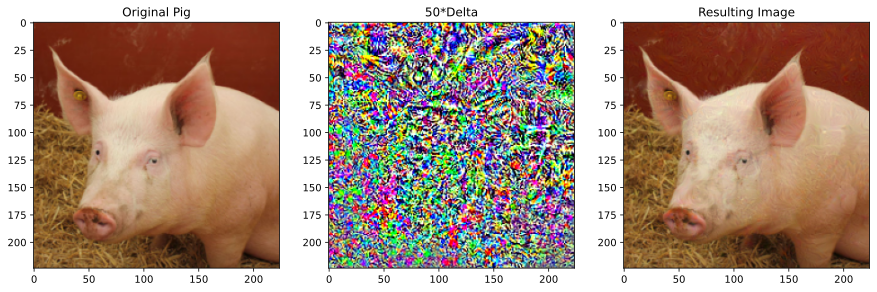

In [51]:
diff_norms = ['infinity',  'L1',  "L2"]
for i in range(len(diff_norms)):
    print("seeing how the function  does  for the Crayfish with norrm "+diff_norms[i])
    adversarial_targeted_attack(target = 1, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = True, times_ten_ = False, learning_rate = 5e-3, epsilon = 2./255)

seeing how the function  does  for the Crayfish with norrm infinity
0 20.759668350219727
10 -3.364849328994751
20 -13.285085678100586
30 -31.751359939575195
40 -62.72317886352539
50 -91.94762420654297
60 -126.92459869384766
70 -141.6192169189453
80 -176.84814453125
90 -204.21578979492188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: crayfish
The Prediction Confidence Is: 0.0


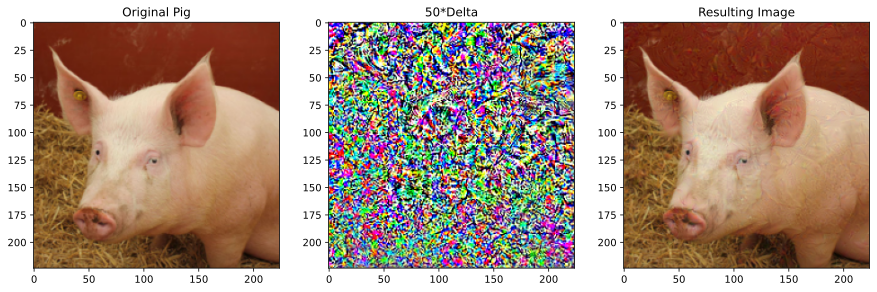

seeing how the function  does  for the Crayfish with norrm L1
0 20.759668350219727
10 -3.364849328994751
20 -13.285085678100586
30 -31.751359939575195
40 -62.72317886352539
50 -91.94762420654297
60 -126.92459869384766
70 -141.6192169189453
80 -176.84814453125
90 -204.21578979492188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: crayfish
The Prediction Confidence Is: 0.0


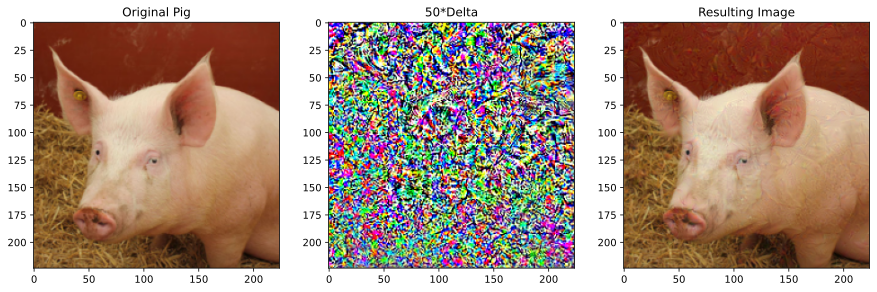

seeing how the function  does  for the Crayfish with norrm L2
0 20.759668350219727
10 -3.364849328994751
20 -13.285085678100586
30 -31.751359939575195
40 -62.72317886352539
50 -91.94762420654297
60 -126.92459869384766
70 -141.6192169189453
80 -176.84814453125
90 -204.21578979492188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: crayfish
The Prediction Confidence Is: 0.0


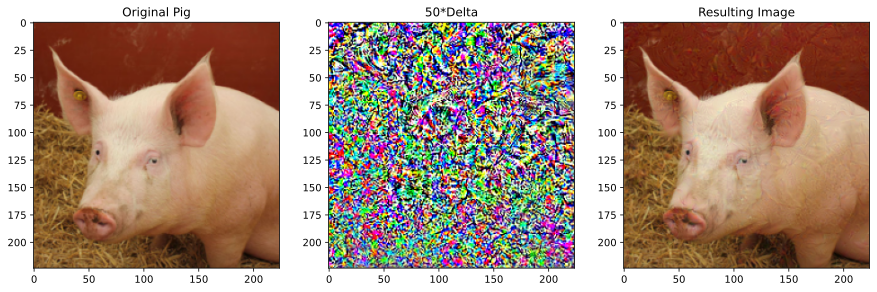

In [48]:

#print("seeing how the function  does  for the craryfish index ")
diff_norms = ['infinity',  'L1',  "L2"]
for i in range(len(diff_norms)):
    print("seeing how the function  does  for the Crayfish with norrm "+diff_norms[i])
    adversarial_targeted_attack(target = 124, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = True, times_ten_ = False, learning_rate = 5e-3, epsilon = 2./255)

seeing how the function  does  for the Vizzla with norrm infinity
0 19.260082244873047
10 -0.6986703872680664
20 -13.255864143371582
30 -30.960886001586914
40 -44.43111801147461
50 -52.938140869140625
60 -73.68252563476562
70 -84.52925109863281
80 -100.91742706298828
90 -106.94364929199219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: vizsla
The Prediction Confidence Is: 0.0


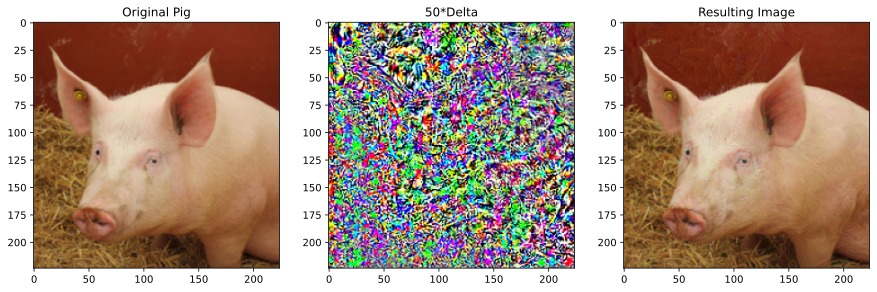

seeing how the function  does  for the Vizzla with norrm L1
0 19.260082244873047
10 -0.6986703872680664
20 -13.255864143371582
30 -30.960886001586914
40 -44.43111801147461
50 -52.938140869140625
60 -73.68252563476562
70 -84.52925109863281
80 -100.91742706298828
90 -106.94364929199219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: vizsla
The Prediction Confidence Is: 0.0


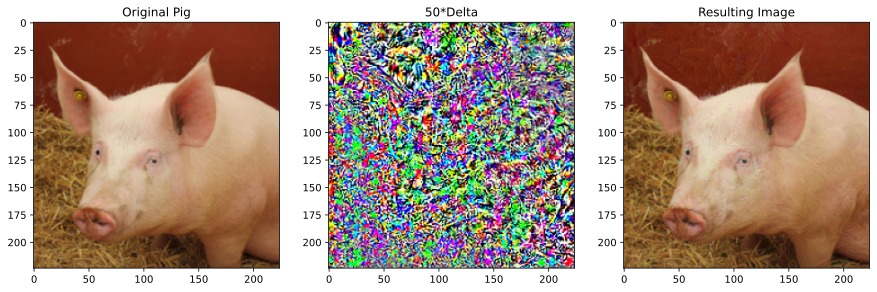

seeing how the function  does  for the Vizzla with norrm L2
0 19.260082244873047
10 -0.6986703872680664
20 -13.255864143371582
30 -30.960886001586914
40 -44.43111801147461
50 -52.938140869140625
60 -73.68252563476562
70 -84.52925109863281
80 -100.91742706298828
90 -106.94364929199219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: vizsla
The Prediction Confidence Is: 0.0


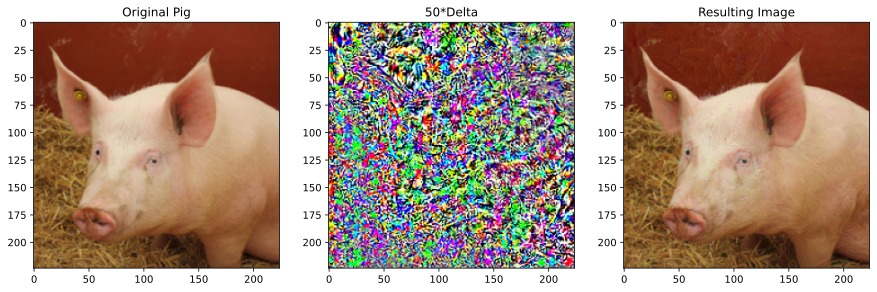

In [49]:
diff_norms = ['infinity',  'L1',  "L2"]
for i in range(len(diff_norms)):
    print("seeing how the function  does  for the Vizzla with norrm "+diff_norms[i])
    adversarial_targeted_attack(target = 211, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = True, times_ten_ = False, learning_rate = 5e-3, epsilon = 2./255)

seeing how the function  does  for the Cowboyboot with norrm infinity
0 21.00800132751465
10 -3.82137393951416
20 -26.62462615966797
30 -55.583492279052734
40 -86.50883483886719
50 -106.3849868774414
60 -121.39617156982422
70 -130.74539184570312
80 -139.57406616210938
90 -153.3244171142578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: cowboy_boot
The Prediction Confidence Is: 0.0


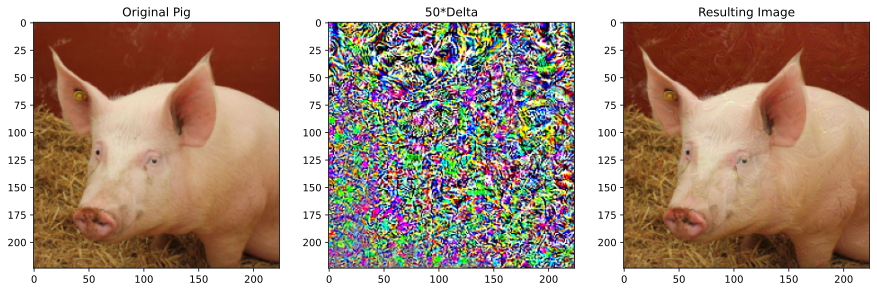

seeing how the function  does  for the Cowboyboot with norrm L1
0 21.00800132751465
10 -3.82137393951416
20 -26.62462615966797
30 -55.583492279052734
40 -86.50883483886719
50 -106.3849868774414
60 -121.39617156982422
70 -130.74539184570312
80 -139.57406616210938
90 -153.3244171142578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: cowboy_boot
The Prediction Confidence Is: 0.0


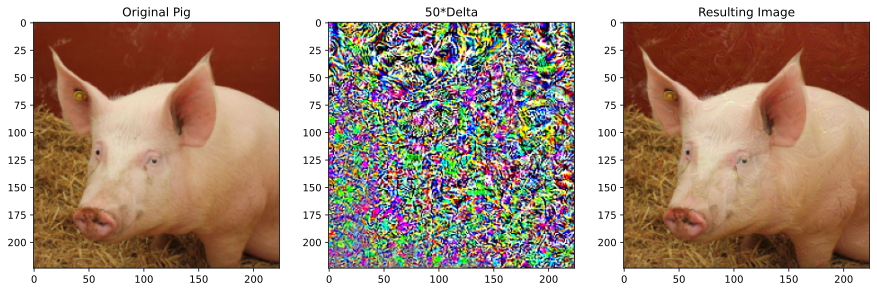

seeing how the function  does  for the Cowboyboot with norrm L2
0 21.00800132751465
10 -3.82137393951416
20 -26.62462615966797
30 -55.583492279052734
40 -86.50883483886719
50 -106.3849868774414
60 -121.39617156982422
70 -130.74539184570312
80 -139.57406616210938
90 -153.3244171142578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The True class Probability Is: 0.0
The Predicted Classification Is: cowboy_boot
The Prediction Confidence Is: 0.0


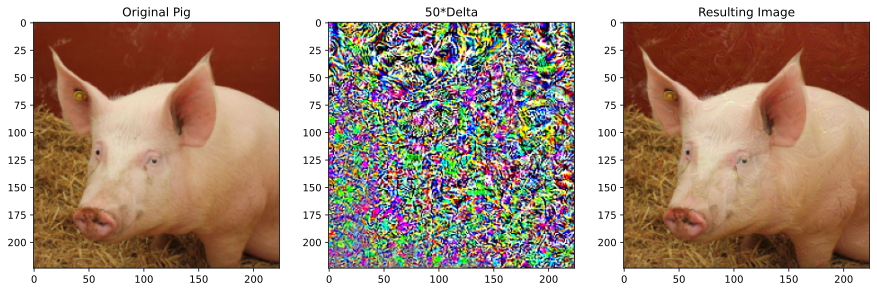

In [50]:
diff_norms = ['infinity',  'L1',  "L2"]
for i in range(len(diff_norms)):
    print("seeing how the function  does  for the Cowboyboot with norrm "+diff_norms[i])
    adversarial_targeted_attack(target = 514, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = True, times_ten_ = False, learning_rate = 5e-3, epsilon = 2./255)

### QUESTION 2

2) Repeat the previous exercise, but use 3-4 different learning rates in SGD to see if you can find an even better adversarial example. in each case.  Report on the total loss in each case.

In [54]:
diff_norms = ['infinity',  'L1',  "L2"]
lr = [.1, .01, .001]
for i in range(len(diff_norms)):
    for  j in range(len(lr)):
        print("seeing how the function  does  for the Crayfish with norrm "+diff_norms[i] +" "+ str(lr[j]))
        adversarial_targeted_attack(target = 124, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = False, times_ten_ = False, learning_rate = lr[j], epsilon = 2./255)
        print(" ")
    print(" ")
    print(" ")


seeing how the function  does  for the Crayfish with norrm infinity 0.1
0 20.759668350219727
10 -44.173343658447266
20 -122.26402282714844
30 -174.39773559570312
40 -217.36834716796875
50 -254.31668090820312
60 -280.81005859375
70 -321.2781066894531
80 -331.0382080078125
90 -349.7169494628906
The True class Probability Is: 0.0
The Predicted Classification Is: crayfish
The Prediction Confidence Is: 0.0
seeing how the function  does  for the Crayfish with norrm infinity 0.01
0 20.759668350219727
10 -7.865058422088623
20 -42.45063781738281
30 -89.32608795166016
40 -128.66717529296875
50 -181.79505920410156
60 -222.08319091796875
70 -246.2863006591797
80 -265.3006286621094
90 -289.4941711425781
The True class Probability Is: 0.0
The Predicted Classification Is: crayfish
The Prediction Confidence Is: 0.0
seeing how the function  does  for the Crayfish with norrm infinity 0.001
0 20.759668350219727
10 8.871784210205078
20 3.7382068634033203
30 0.6378219127655029
40 -1.726785659790039
50 -3.9

In [56]:
diff_norms = ['infinity',  'L1',  "L2"]
lr = [.1, .01, .001]
for i in range(len(diff_norms)):
    for  j in range(len(lr)):
        print("seeing how the function  does  for the Vizla with norrm "+diff_norms[i] +" "+ str(lr[j]))
        adversarial_targeted_attack(target = 211, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = False, times_ten_ = False, learning_rate = lr[j], epsilon = 2./255)
        print(" ")
    print(" ")
    print(" ")



seeing how the function  does  for the Vizla with norrm infinity 0.1
0 19.260082244873047
10 -27.734363555908203
20 -57.53846740722656
30 -90.61570739746094
40 -127.4969253540039
50 -153.86485290527344
60 -161.32127380371094
70 -193.5113067626953
80 -213.342041015625
90 -224.74993896484375
The True class Probability Is: 0.0
The Predicted Classification Is: vizsla
The Prediction Confidence Is: 0.0
 
seeing how the function  does  for the Vizla with norrm infinity 0.01
0 19.260082244873047
10 -10.167750358581543
20 -36.33589172363281
30 -59.91229248046875
40 -77.25702667236328
50 -104.49805450439453
60 -118.55197143554688
70 -128.89930725097656
80 -143.3953094482422
90 -158.35426330566406
The True class Probability Is: 0.0
The Predicted Classification Is: vizsla
The Prediction Confidence Is: 0.0
 
seeing how the function  does  for the Vizla with norrm infinity 0.001
0 19.260082244873047
10 8.445831298828125
20 4.389041900634766
30 2.225940227508545
40 0.6134262084960938
50 -1.0298633575

In [57]:
diff_norms = ['infinity',  'L1',  "L2"]
lr = [.1, .01, .001]
for i in range(len(diff_norms)):
    for  j in range(len(lr)):
        print("seeing how the function  does  for the Cowboyboot with norrm "+diff_norms[i]+" "+ str(lr[j]))
        adversarial_targeted_attack(target = 514, img_ = pig_tensor, norm_ = diff_norms[i], print_ = True, plot_ = False, times_ten_ = False, learning_rate = lr[j], epsilon = 2./255)
        print(" ")
    print(" ")
    print(" ")



seeing how the function  does  for the Cowboyboot with norrm infinity 0.1
0 21.00800132751465
10 -57.850372314453125
20 -107.81258392333984
30 -134.31944274902344
40 -175.25927734375
50 -196.20144653320312
60 -211.9281005859375
70 -222.76470947265625
80 -231.99325561523438
90 -242.7721405029297
The True class Probability Is: 0.0
The Predicted Classification Is: cowboy_boot
The Prediction Confidence Is: 0.0
 
seeing how the function  does  for the Cowboyboot with norrm infinity 0.01
0 21.00800132751465
10 -17.5526123046875
20 -64.16002655029297
30 -100.8519287109375
40 -120.53714752197266
50 -135.48699951171875
60 -153.0707550048828
70 -163.67013549804688
80 -170.1252899169922
90 -184.6163787841797
The True class Probability Is: 0.0
The Predicted Classification Is: cowboy_boot
The Prediction Confidence Is: 0.0
 
seeing how the function  does  for the Cowboyboot with norrm infinity 0.001
0 21.00800132751465
10 9.199832916259766
20 4.598043441772461
30 1.5237150192260742
40 -1.23082280158

### QUESTION 3 
3) In the Linear Models (chapter 2) notebook, derive the optimal adversary perturbation for the mean-squared error loss instead of the logistic loss.  Can you still rewrite the min-max problem as a minimizing problem for linear models?  If so, how is the problem stated?

 




In [60]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Train Err	Train Loss	Test Err	Test Loss
0.006948	0.016861	0.000946	0.002886
0.001421	0.005578	0.000473	0.002492
0.001263	0.004404	0.000473	0.002361
0.001105	0.003763	0.000473	0.002345
0.001105	0.003572	0.000473	0.002124
0.000790	0.003250	0.000946	0.002099
0.000869	0.002996	0.000473	0.002151
0.000790	0.002854	0.000946	0.001999
0.000711	0.002739	0.000946	0.001951
0.000711	0.002501	0.000473	0.001943
(0.857210401891253, 22.34608274148711)


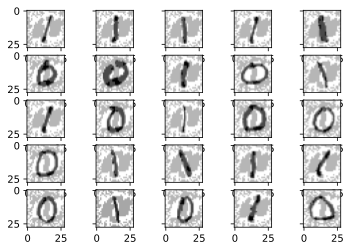

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

X_test = (test_loader.dataset.data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.targets

epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)

def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.MSELoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

### QUESTION 4 

4) Following chapter 3 from the same blog, use FGSM to create adversarial examples for MNIST with varying levels of epsilon.  What is the minimal epsilon that still causes a 50% miss-classification error?

 




In [71]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cpu")
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)  

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt", map_location=torch.device('cpu')))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt", map_location=torch.device('cpu')))
model_cnn.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))

for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [72]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [73]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.055)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.05)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.11)[0])

2-layer DNN: 0.5137
4-layer DNN: 0.5376
        CNN: 0.503


### QUESTION  5 

5) Now use PGD from the third chapter to find adversarial images that missclassify about 50% of the time (for the limited data we are using).  What values of alpha and epsilon work the best here?  Are there multiple values of alpha and epsilon that are allowed in this case?

 




In [74]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.05, 1000, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.042, 0.01, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.075, 0.01, 40)[0])

2-layer DNN: 0.5141
4-layer DNN: 0.5063
CNN: 0.4937


As you can see from the chosen values of alpha and epsilon, the model is heavily influenced by the value of epsilon, but not as much by the value of alpha. Choosing 0.01 or 1000 for alpha makes little difference.


### QUESTION 6 

6) Create an adversarial robust classifier of your choice for the Fashion MNIST data (sorry but this seemed like the best option after MNIST). You should be able to follow the steps in Chapter 4 relatively closely. Feel free to choose whether you use a convolutional network, or just a ‘deep’ linear ReLU network.

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)





Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [76]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, fgsm, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, fgsm)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")



0.631533	0.260500	0.404200
0.351983	0.232400	0.323000
0.308633	0.216300	0.329200
0.285267	0.192800	0.290400
0.264700	0.174200	0.262500
0.242917	0.165600	0.258600
0.240917	0.162400	0.250900
0.238667	0.162200	0.246600
0.236683	0.161200	0.246800
0.235417	0.161500	0.244500


In [77]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.2445
